# Распознавание лиц с помощью нейросети

Для начала обновим библиотеку для работы с изображениями до той версии, на которой работает то, что нам нужно.

In [86]:
!pip install --upgrade Pillow==6.1.0

Requirement already up-to-date: Pillow==6.1.0 in /usr/local/lib/python3.6/dist-packages (6.1.0)


In [87]:
from matplotlib import pyplot
try:
    from google.colab import drive
    import os
    drive.mount('/content/drive', force_remount=True)
    os.chdir('/content/drive/My Drive/')
except ImportError:
    pass


Mounted at /content/drive


## Задача 1. Детектирование лиц

Перед тем, как распознавать лицо, нам необходимо решить еще одну задачу машинного зрения - детектирование лица. Для этого скачаем библиотеку <code>mtcnn</code> - в ней содержится модель каскадной архитектуры сверточной нейросети, которая хорошо себя показывает в задачах детектирования объектов на фото (<link>https://arxiv.org/abs/1604.02878</link>).

In [88]:
!pip install mtcnn

Посмотрим, всё ли установилось нормально.

In [89]:
%tensorflow_version 1.x

import mtcnn
print(mtcnn.__version__)

0.1.0


Считаем картинку с лицом

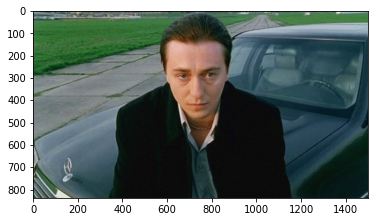

In [90]:
img_path = "/content/drive/MyDrive/Laba5/bezhard3.jpg"
img = pyplot.imread(img_path)
pyplot.imshow(img)
pyplot.show()

Создадим экземпляр нашей нейросети. Запишем результат разметки сети в переменную <code>results</code>

In [91]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18381632654214805727
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15290446820991115178
physical_device_desc: "device: XLA_CPU device"
]


In [92]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
results = detector.detect_faces(img)

Запомним координаты рамки, которую нейросеть расположила вокруг лица

In [93]:
x1, y1, width, height = results[0]['box']
x2, y2 = x1 + width, y1 + height

Обрежем фотографию по полученной рамке

In [94]:
face = img[y1:y2, x1:x2]

И просто посмотрим на результат =)

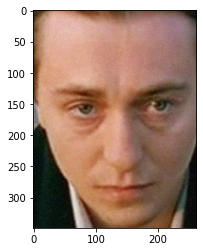

In [95]:
from PIL import Image
import numpy as np

image = Image.fromarray(face)
face_array = np.asarray(image)
pyplot.imshow(face_array)
pyplot.show()

Отлично! Сетка работает! Давайте напишем функцию, которая делает всё то же самое, и проверим работу этой сетки на более сложных примерах.

In [96]:
def extract_face(filename, required_size=(224, 224), resize=False):
    """Функция возвращает массив-лицо и преобразует его к заданному размеру,
    если resize == True
    
    Параметры:
    filename -- строка - путь к файлу с исходным изображением
    required_size -- кортеж из двух целых чисел - размер финального изображения
    resize -- boolean, который определяет, нужно ли менять размер изображения
    
    Возвращает np.ndarray, в котором записано обрезанное изображение с найденным
    на первоначальной картинке лицом
    """
    print(filename)
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    if resize:
        image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def extract_face1(filename,  required_size=(224, 224), resize=False):
    print(filename)
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    if resize:
        image = image.resize(required_size)
    #face_array = np.asarray(image)
    return image

def print_image(img):
    """Выводит изображение на экран"""
    if isinstance(img, str):
        img = pyplot.imread(img)
    pyplot.imshow(img)
    pyplot.show()

/content/drive/MyDrive/Laba5/BezHard.jpg


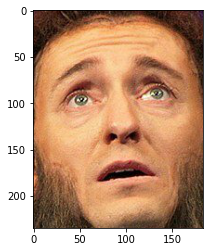

In [97]:
print_image(extract_face("/content/drive/MyDrive/Laba5/BezHard.jpg"))

## Распознавание лиц

В этих ваших интернетах поговаривают, что с этой задачей хорошо справляется архитектура VGGFace. Путем традиционного гуглинга найдем эту архитектуру и реализуем ее в классах keras.

In [98]:
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

Чтобы не собирать гигантскую выборку фотографий и не ждать до пенсии, пока пустая нейронка на ней обучится, съединороссим веса обученной модели из интернетов. Нужно скачать файл: https://drive.google.com/file/d/1soMVD9PGqDam13Fj9fky-OfMjfqLrRYT/view?usp=sharing

In [99]:
from keras.models import model_from_json
model.load_weights('/content/drive/MyDrive/Laba5/vgg_face_weights.h5')

Теперь нам нужно загрузить веса в сетку и зафиксировать их, т.е. сделать так, чтобы при дообучении они не изменялись.

In [100]:
# наш выходной слой с необходимым количеством нейронов в нем
final_layer = Dense(3, activation='softmax')(model.layers[-2].output)

from keras.models import Model
model = Model(model.inputs, final_layer)
for layer in model.layers[:-1]:
    layer.trainable = False

Скомпилируем сетку

In [101]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [102]:
model.summary()

Model: "model_557"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_27_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_2253 (Conv2D)         (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2254 (Conv2D)         (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1121 (MaxPooli (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_29 (ZeroPaddi (None, 114, 114, 64)      0 

Теперь нужно предобработать изображения. 

In [103]:
import os
dir1 = "/content/drive/MyDrive/Laba5/train/Beztrain/"
dir2 = "/content/drive/MyDrive/Laba5/train/Dyjtrain/"
dir3 = "/content/drive/MyDrive/Laba5/train/Vdovtrain/"
dir4 = "/content/drive/MyDrive/Laba5/test/Beztest/"
dir5 = "/content/drive/MyDrive/Laba5/test/Dyjtest/"
dir6 = "/content/drive/MyDrive/Laba5/test/Vdovtest/"

files1 = os.listdir(dir1)
files2 = os.listdir(dir2)
files3 = os.listdir(dir3)
files4 = os.listdir(dir4)
files5 = os.listdir(dir5)
files6 = os.listdir(dir6)

Проведем детектирование лиц на каждой картинке

In [ ]:
for i in range(1,21):
    im=extract_face1('/content/drive/MyDrive/Laba5/Bez/'+str(i) +'.jpg', resize=True)
    im.save('/content/drive/MyDrive/Laba5/train/Beztrain/'+str(i) +'.jpg')
for i in range(1,21):
    im=extract_face1('/content/drive/MyDrive/Laba5/Dyj/'+str(i) +'.jpg', resize=True)
    im.save('/content/drive/MyDrive/Laba5/train/Dyjtrain/'+str(i) +'.jpg')
for i in range(1,21):
    im=extract_face1('/content/drive/MyDrive/Laba5/Vdov/'+str(i) +'.jpg', resize=True)
    im.save('/content/drive/MyDrive/Laba5/train/Vdovtrain/'+str(i) +'.jpg')
for i in range(1,3):
    im=extract_face1('/content/drive/MyDrive/Laba5/Bez1/'+str(i) +'.jpg', resize=True)
    im.save('/content/drive/MyDrive/Laba5/test/Beztest/'+str(i) +'.jpg')
for i in range(1,3):
    im=extract_face1('/content/drive/MyDrive/Laba5/Dyj1/'+str(i) +'.jpg', resize=True)
    im.save('/content/drive/MyDrive/Laba5/test/Dyjtest/'+str(i) +'.jpg')
for i in range(1,3):
    im=extract_face1('/content/drive/MyDrive/Laba5/Vdov1/'+str(i) +'.jpg', resize=True)
    im.save('/content/drive/MyDrive/Laba5/test/Vdovtest/'+str(i) +'.jpg')

/content/drive/MyDrive/Laba5/Bez/1.jpg
/content/drive/MyDrive/Laba5/Bez/2.jpg
/content/drive/MyDrive/Laba5/Bez/3.jpg
/content/drive/MyDrive/Laba5/Bez/4.jpg
/content/drive/MyDrive/Laba5/Bez/5.jpg
/content/drive/MyDrive/Laba5/Bez/6.jpg
/content/drive/MyDrive/Laba5/Bez/7.jpg
/content/drive/MyDrive/Laba5/Bez/8.jpg
/content/drive/MyDrive/Laba5/Bez/9.jpg
/content/drive/MyDrive/Laba5/Bez/10.jpg
/content/drive/MyDrive/Laba5/Bez/11.jpg
/content/drive/MyDrive/Laba5/Bez/12.jpg
/content/drive/MyDrive/Laba5/Bez/13.jpg
/content/drive/MyDrive/Laba5/Bez/14.jpg
/content/drive/MyDrive/Laba5/Bez/15.jpg
/content/drive/MyDrive/Laba5/Bez/16.jpg
/content/drive/MyDrive/Laba5/Bez/17.jpg
/content/drive/MyDrive/Laba5/Bez/18.jpg
/content/drive/MyDrive/Laba5/Bez/19.jpg
/content/drive/MyDrive/Laba5/Bez/20.jpg
/content/drive/MyDrive/Laba5/Dyj/1.jpg
/content/drive/MyDrive/Laba5/Dyj/2.jpg
/content/drive/MyDrive/Laba5/Dyj/3.jpg
/content/drive/MyDrive/Laba5/Dyj/4.jpg
/content/drive/MyDrive/Laba5/Dyj/5.jpg
/content/drive

Сформируем выборки

In [104]:
images1 = [pyplot.imread(os.path.join(dir1, i))
           for i in files1]
images2 = [pyplot.imread(os.path.join(dir2, i))
           for i in files2]
images3 = [pyplot.imread(os.path.join(dir3, i))
           for i in files3]
images4 = [pyplot.imread(os.path.join(dir4, i))
           for i in files4]
images5 = [pyplot.imread(os.path.join(dir5, i))
           for i in files5]
images6 = [pyplot.imread(os.path.join(dir6, i))
           for i in files6]

In [105]:
X_train = images1 + images2 + images3
y_train = [[1, 0, 0]] * len(images1) + [[0, 1, 0]] * len(images2) + [[0, 0, 1]] * len(images3)

X_test = images4 + images5 + images6
y_test = [[1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1]]

Проведем аугментацию тренировочной выборки

In [106]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [107]:
train = train_datagen.flow(np.asarray(X_train), np.asarray(y_train))

In [117]:
%%time
model.fit_generator(train, epochs=100, verbose=2)

Epoch 1/100
 - 34s - loss: 1.1899 - accuracy: 0.6667
Epoch 2/100
 - 31s - loss: 1.1522 - accuracy: 0.6667
Epoch 3/100
 - 31s - loss: 1.1358 - accuracy: 0.6667
Epoch 4/100
 - 31s - loss: 1.0485 - accuracy: 0.6667
Epoch 5/100
 - 31s - loss: 1.0874 - accuracy: 0.6667
Epoch 6/100
 - 31s - loss: 1.0411 - accuracy: 0.6667
Epoch 7/100
 - 31s - loss: 1.0071 - accuracy: 0.6667
Epoch 8/100
 - 31s - loss: 0.9546 - accuracy: 0.6667
Epoch 9/100
 - 31s - loss: 0.9357 - accuracy: 0.6667
Epoch 10/100
 - 31s - loss: 0.9233 - accuracy: 0.6667
Epoch 11/100
 - 33s - loss: 0.8934 - accuracy: 0.6667
Epoch 12/100
 - 31s - loss: 0.8306 - accuracy: 0.6667
Epoch 13/100
 - 31s - loss: 0.7948 - accuracy: 0.6667
Epoch 14/100
 - 31s - loss: 0.7827 - accuracy: 0.6667
Epoch 15/100
 - 31s - loss: 0.7439 - accuracy: 0.6667
Epoch 16/100
 - 31s - loss: 0.7230 - accuracy: 0.6667
Epoch 17/100
 - 31s - loss: 0.7118 - accuracy: 0.6667
Epoch 18/100
 - 31s - loss: 0.6775 - accuracy: 0.6667
Epoch 19/100
 - 31s - loss: 0.6776 - 

In [118]:
model.save_weights("l5_face_rec_model_weightsnorm.h5")

In [119]:
model.load_weights("l5_face_rec_model_weightsnorm.h5")

In [120]:
model.predict(np.asarray(X_test))

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 5.5299023e-24],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

Можно убедиться, что модель работает с очень высокой точностью

Посмотрим на фотографии из тестовой выборки

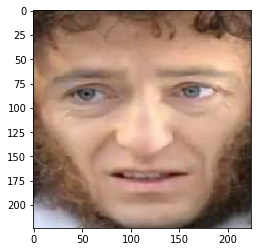

In [121]:
pyplot.imshow(Image.fromarray(X_test[0]))
pyplot.show()

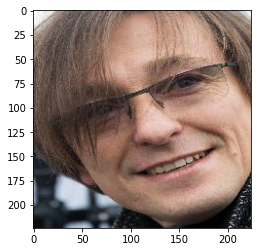

In [122]:
pyplot.imshow(Image.fromarray(X_test[1]))
pyplot.show()

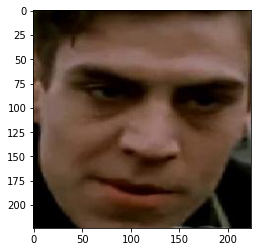

In [123]:
pyplot.imshow(Image.fromarray(X_test[2]))
pyplot.show()

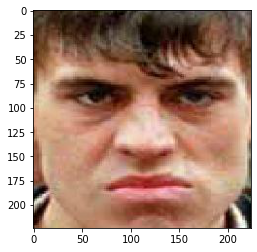

In [124]:
pyplot.imshow(Image.fromarray(X_test[3]))
pyplot.show()

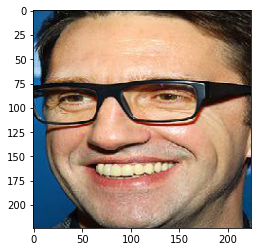

In [125]:
pyplot.imshow(Image.fromarray(X_test[4]))
pyplot.show()

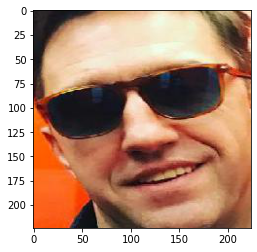

In [126]:
pyplot.imshow(Image.fromarray(X_test[5]))
pyplot.show()